In [7]:
## A few samples cobbled together from various places
# https://people.csail.mit.edu/hubert/pyaudio/docs/ 
# https://realpython.com/playing-and-recording-sound-python/#pyaudio 
# https://gist.github.com/mabdrabo/8678538

In [36]:
# install portaudio first via brew install portaudio 
# pip install PyAudio

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyaudio
import time
import wave
from scipy import signal

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
import numpy as np
from IPython import display

In [21]:
CHUNK = 8192
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100

## Record Wave

In [26]:
RECORD_SECONDS = 5

WAVE_OUTPUT_FILENAME = "recording.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


## Play it back

In [37]:
wf = wave.open(WAVE_OUTPUT_FILENAME)

# instantiate PyAudio (1)
p = pyaudio.PyAudio()

# open stream (2)
stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                channels=wf.getnchannels(),
                rate=wf.getframerate(),
                output=True)

# read data
data = wf.readframes(CHUNK)

# play stream (3)
while len(data) > 0:
    stream.write(data)
    data = wf.readframes(CHUNK)

# stop stream (4)
stream.stop_stream()
stream.close()

# close PyAudio (5)
p.terminate()

In [8]:
def fft(data, rate=44100):
    chunk_size = data.shape[0]
    spec_x = np.fft.fftfreq(chunk_size, d = 1.0 / float(rate))  
    y = np.fft.fft(data)
    spec_y = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in y]
    return spec_x, spec_y, y
        

In [9]:
def plot_fft(wave_data, spec_x, spec_y, max_amp=15000):
    plt.clf()
    plt.subplot(311)
    plt.plot(wave_data)
    plt.xlabel("time [sample]")
    plt.ylabel("amplitude")

    plt.subplot(312)
    plt.plot(spec_x, spec_y)

    plt.axis([0, RATE / 2, 0, max_amp])
    plt.xlabel("Hz")
    plt.ylabel("spectrum")
    
    display.display(plt.gcf())
    display.clear_output(wait=True)



In [10]:
def plot_spec(wave_data, DIV=4, WIN=2000):
    # TOOD: add a max_freq_to_plot or range instead of div
    plt.clf()
    
    win_name = 'hann'
    window = signal.get_window(win_name, WIN)
    #window = signal.get_window( ('tukey', 0.8) , WIN, )
    f, t, Sxx = signal.spectrogram(wave_data, fs=RATE, window=window, nperseg=WIN, 
                                   noverlap=WIN//2, scaling='spectrum')
    
    max_y = f.shape[0]//DIV
    
    plt.pcolormesh(t, f[:max_y], Sxx[:max_y])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    
    i = Sxx.max(1).argmax()
    max_val = Sxx.max(1)[i]
    max_freq = f[i]
    plt.title("Max freq: {:6.1f}  val:  {:6.1f}".format(max_freq, max_val))
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    

## Live spectrogram 

In [11]:
figsize(12,11)

stop stream


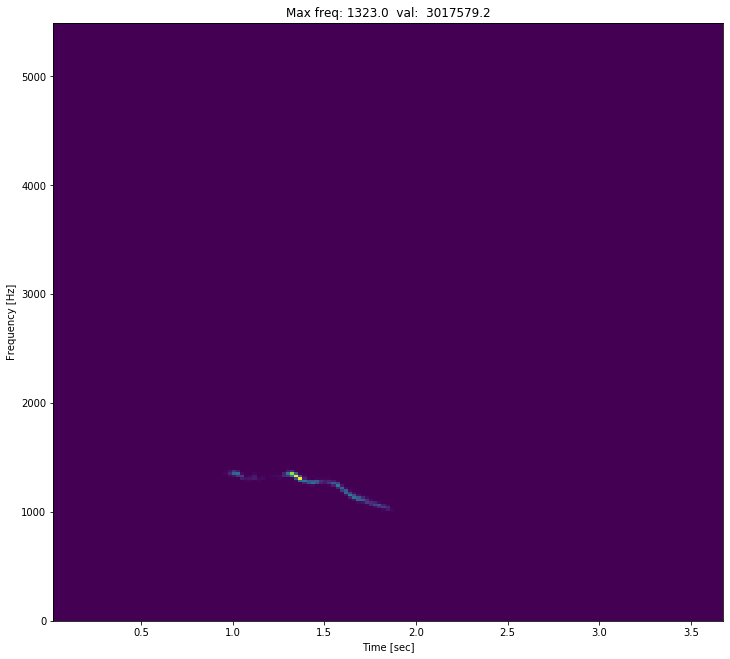

In [25]:
# Use 'stream_callback' for non-blocking loop and plot the audio data 

p = pyaudio.PyAudio()

frames = []
max_frames = 50

def callback(in_data, frame_count, time_info, status):
    frames.append(np.frombuffer(in_data, dtype=np.int16))
    if len(frames) > max_frames:
        frames.pop(0)
    return (in_data, pyaudio.paContinue)

start_t = time.time() 

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK,
                stream_callback=callback)

stream.start_stream()

use_fft = False

while True:
    try:
        
        if len(frames) >= 4:
            #wave_data = frames[-1]
            #wave_data = np.concatenate( (frames[-4], frames[-3], frames[-2], frames[-1]) )
            wave_data = np.concatenate( tuple(frames[-20:]) )

            if use_fft:
                spec_x, spec_y, y = fft(wave_data, rate=RATE)
                plot_fft(wave_data, spec_x, spec_y)
            else:
                plot_spec(wave_data)
        
        time.sleep(0.01)
                
    except KeyboardInterrupt:
        break


print("stop stream")

# stop stream (6)
stream.stop_stream()
stream.close()
p.terminate()


## Read wav and plot 

In [28]:
def read_wav(wav_file):
    wf = wave.open(wav_file, 'rb')
    data = "_"
    frames = None
    while data:
        data = wf.readframes(CHUNK)
        npdata = np.frombuffer(data, dtype=np.int16)
        if frames is None:
            frames = npdata
        else:
            frames = np.concatenate((frames, npdata))
    wf.close()
    return frames


In [29]:
wav_file = "recording.wav"
frames = read_wav(wav_file)

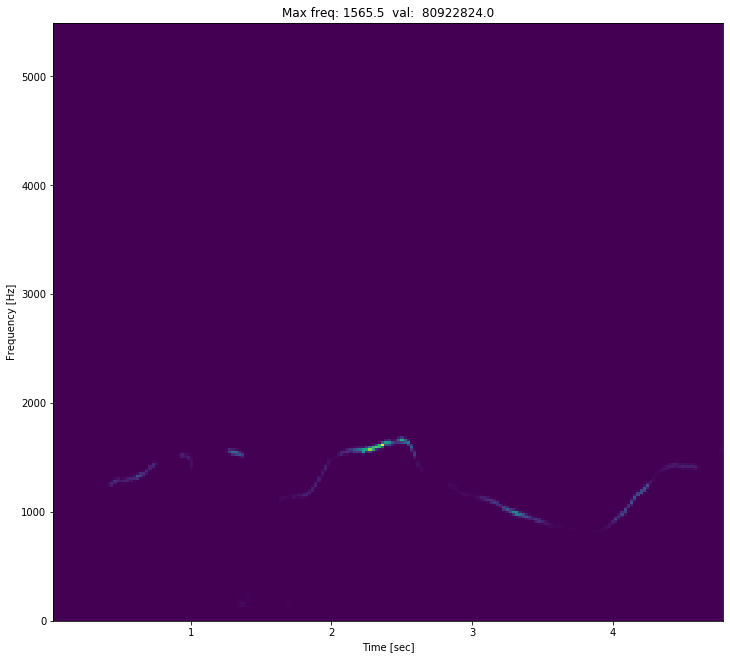

In [35]:
plot_spec(frames)